# Proyecto de segmentación: conducción autónoma

# 1. Lectura y visualización de un dataset de segmentation

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
dataset_path = './TrainImages'
filenames = os.listdir(dataset_path)
filenames.sort()
image_list = []
for filename in filenames:  
   image_list.append(dataset_path + '/' + filename)


masks_list = []    
dataset_path = './TrainLabel'
filenames = os.listdir(dataset_path)
filenames.sort()
for filename in filenames:  
   masks_list.append(dataset_path + '/' + filename)    

image_list_test = []    
dataset_path = './TestImages'
filenames = os.listdir(dataset_path)
filenames.sort()
for filename in filenames:  
   image_list_test.append(dataset_path + '/' + filename)    

masks_list_test = []    
dataset_path = './TestLabels'
filenames = os.listdir(dataset_path)
filenames.sort()
for filename in filenames:  
   masks_list_test.append(dataset_path + '/' + filename)    




In [3]:
def load_data(images_path, masks_path):
  samples = {'images': [], 'masks': []}

  for i in range(len(images_path)):
    img = plt.imread(images_path[i])
    mask = plt.imread(masks_path[i])
    img = cv2.resize(img, (256, 256))
    masks = cv2.resize(mask, (256, 256))

    samples['images'].append(img)
    samples['masks'].append(masks)

  samples = {
      'images': np.array(samples['images']),
      'masks': np.array(samples['masks']),
  }

  return samples

In [4]:
train_samples = load_data(image_list, masks_list)
test_samples = load_data(image_list_test, masks_list_test)

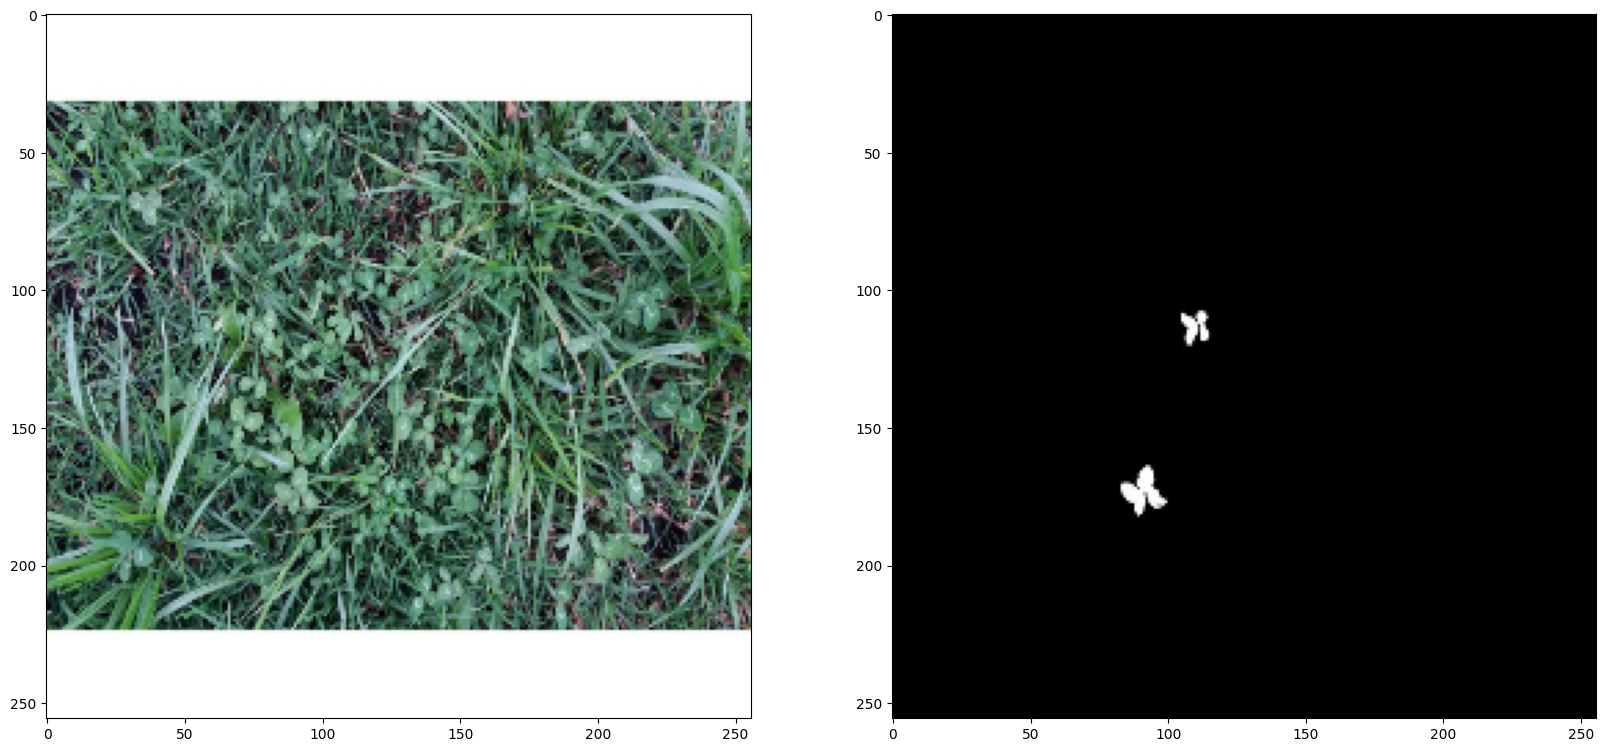

In [5]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(train_samples['images'][10])
plt.subplot(1, 2, 2)
plt.imshow(train_samples['masks'][10])
plt.show()

# 2. Creando una red U-Net para segmentación.

In [6]:
def create_conv_block(input_tensor, num_filters):
  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [7]:
def create_unet(input_shape, num_filters=16, dropout=0.1):
  # Encoder
  c1 = create_conv_block(input_shape, num_filters * 1)
  p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
  p1 = tf.keras.layers.Dropout(dropout)(p1)

  c2 = create_conv_block(p1, num_filters * 2)
  p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
  p2 = tf.keras.layers.Dropout(dropout)(p2)

  c3 = create_conv_block(p2, num_filters * 4)
  p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
  p3 = tf.keras.layers.Dropout(dropout)(p3)

  c4 = create_conv_block(p3, num_filters * 8)
  p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
  p4 = tf.keras.layers.Dropout(dropout)(p4)

  c5 = create_conv_block(p4, num_filters * 16)

  # Decoder
  u6 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  u6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = create_conv_block(u6, num_filters*8)


  u7 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = create_conv_block(u7, num_filters*4)

  u8 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = create_conv_block(u8, num_filters*2)

  u9 = tf.keras.layers.Convolution2DTranspose(num_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1])
  u9 = tf.keras.layers.Dropout(dropout)(u9)
  c9 = create_conv_block(u9, num_filters*1)


  output = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
  model = tf.keras.Model(inputs = [input_shape], outputs = [output])

  return model 

In [8]:
inputs = tf.keras.layers.Input((256, 256, 3))
model = create_unet(inputs)

In [9]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
model_history = model.fit(train_samples['images'], train_samples['masks'], epochs=200, verbose=1)

Epoch 1/200
32/32 [==============================] - 22s 298ms/step - loss: -1.3892 - accuracy: 0.0110
Epoch 2/200
32/32 [==============================] - 8s 242ms/step - loss: -4.2780 - accuracy: 0.0081
Epoch 3/200
32/32 [==============================] - 7s 227ms/step - loss: -5.8868 - accuracy: 0.0161
Epoch 4/200
32/32 [==============================] - 7s 225ms/step - loss: -7.2948 - accuracy: 0.0125
Epoch 5/200
32/32 [==============================] - 7s 225ms/step - loss: -9.9270 - accuracy: 0.0097
Epoch 6/200
32/32 [==============================] - 7s 224ms/step - loss: -13.4007 - accuracy: 0.0114
Epoch 7/200
32/32 [==============================] - 7s 224ms/step - loss: -16.4482 - accuracy: 0.0078
Epoch 8/200
32/32 [==============================] - 7s 225ms/step - loss: -20.4689 - accuracy: 0.0094
Epoch 9/200
32/32 [==============================] - 7s 225ms/step - loss: -25.6376 - accuracy: 0.0124
Epoch 10/200
32/32 [==============================] - 7s 225ms/step - loss: -

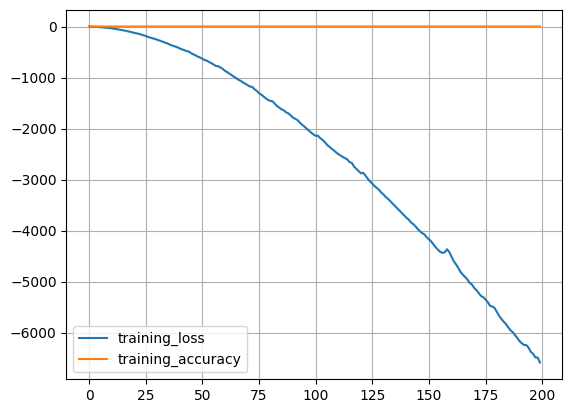

In [13]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)

In [14]:
def predict_test_samples(val_map, model):
  img = val_map['images']
  mask = val_map['masks']

  test_images = np.array(img)

  predictions = model.predict(test_images)

  return predictions,  test_images, mask

In [15]:
def plot_images(test_image, predicted_maks, ground_truth):
  plt.figure(figsize=(20, 20))

  plt.subplot(1, 3, 1)
  plt.imshow(test_image)
  plt.title('Image')

  plt.subplot(1, 3, 2)
  plt.imshow(predicted_maks)
  plt.title('Predicted mask')

  plt.subplot(1, 3, 3)
  plt.imshow(ground_truth)
  plt.title('Ground truth mask')

In [16]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(test_samples, model)

16/16 [==============================] - 2s 118ms/step


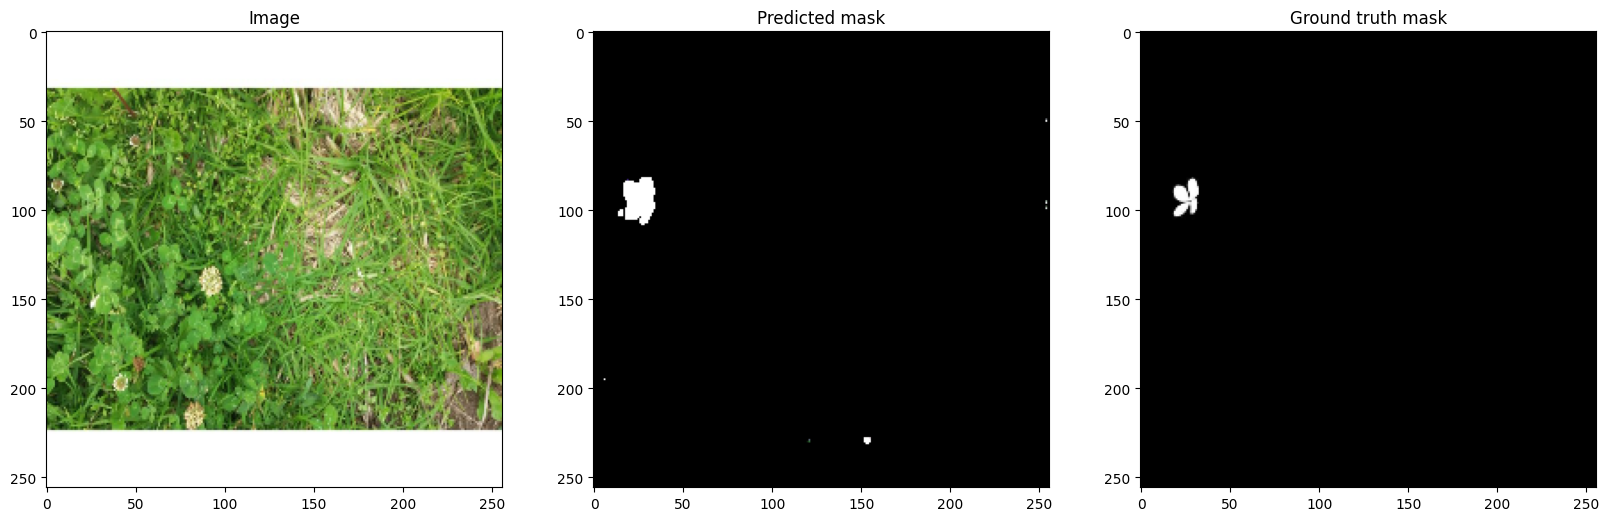

In [19]:
plot_images(test_images[100], predicted_masks[100], ground_truth_masks[100])

In [20]:
model.save('four_leaf_clover_seeker.h5')